In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fbr-vn/VNFoodDrinkReviews.xlsx
/kaggle/input/fbr-vn-2/VNFoodDrinkReviews.xlsx


 Cài đặt thư viện cần thiết

In [2]:
# For read excel format form pandas
!pip install openpyxl
# For Vietnamese word_segment
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 58.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.8 MB/s eta 0:00:00


Import các thư viện cần thiết

In [3]:
    import os
    import torch
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    from pyvi import ViTokenizer
    from gensim.utils import simple_preprocess
    from sklearn.model_selection import train_test_split, StratifiedKFold
    from sklearn.metrics import classification_report, confusion_matrix
    
    import torch.nn as nn
    from torch.optim import AdamW
    from torch.utils.data import Dataset, DataLoader
    
    from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging
    
    import warnings
    warnings.filterwarnings("ignore")
    
    logging.set_verbosity_error()

Định nghĩa hàm khởi tạo seed (random state)

In [4]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 10
N_SPLITS = 10

Đọc dữ liệu

In [5]:
# Load dataset
def get_data(path):
    df = pd.read_excel(path, sheet_name='Sheet1')
    df.columns = ['Emotion', 'Sentence']
    return df

df = get_data('/kaggle/input/fbr-vn-2/VNFoodDrinkReviews.xlsx')

Chia dữ liệu train, valid, test

In [6]:
# Split dataset
train_df, test_df = train_test_split(df, test_size=0.1, stratify=df['Emotion'], random_state=86)
train_df, valid_df = train_test_split(train_df, test_size=0.1, stratify=train_df['Emotion'], random_state=86)

In [7]:
train_df = pd.concat([train_df, valid_df], ignore_index=True)
skf = StratifiedKFold(n_splits=N_SPLITS)
for fold, (_, val_) in enumerate(skf.split(X=train_df, y=train_df.Emotion)):
    train_df.loc[val_, "kfold"] = fold

Trực quan hóa dữ liệu

In [8]:
train_df.sample(5)

,Emotion,Sentence,kfold
3461,Negative,Đặt bánh cuốn thịt nướng\nĐói meo chờ 30p mới ...,6.0
4364,Positive,Bánh tráng cuốn thịt heo luộc ở đây khá ngon đ...,8.0
3174,Positive,Vị phô mai rong biển cay ăn ổn nhé\nHộp 30k 4 ...,6.0
1246,Neutral,"Nước uống ổn, không có gì đặc biệt",2.0
1660,Negative,"Phục vụ chậm, mình phải đợi hơn 20 phút mới có...",3.0


In [9]:
train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4950 entries, 0 to 4949
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Emotion   4950 non-null   object 
 1   Sentence  4949 non-null   object 
 2   kfold     4950 non-null   float64
dtypes: float64(1), object(2)
memory usage: 116.1+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 551 entries, 2520 to 2643
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Emotion   551 non-null    object
 1   Sentence  551 non-null    object
dtypes: object(2)
memory usage: 12.9+ KB


(None, None)

<Axes: xlabel='Emotion', ylabel='count'>

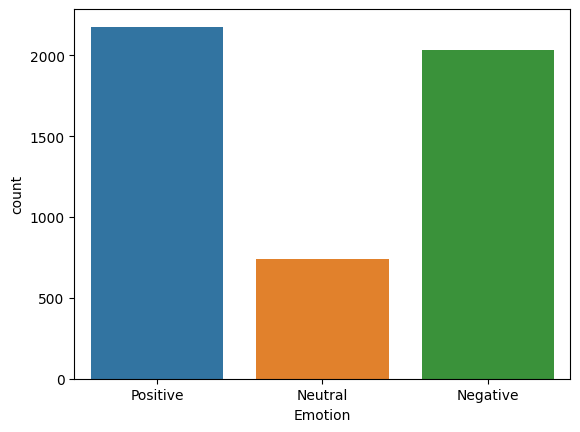

In [10]:
sns.countplot(x='Emotion', data=train_df)

Load tokenizer PhoBERT

In [11]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

Xây dựng class xử lý dữ liệu

In [12]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=120):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return 
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self,text):
        if text=='Positive':
            return 0
        elif text=='Negative':
            return 1
        elif text=='Neutral':
            return 2
        else:
            return 3

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['Sentence']
        text = ' '.join(simple_preprocess(text))
        text = ViTokenizer.tokenize(text)
        label = self.labelencoder(row['Emotion'])

        return text, label

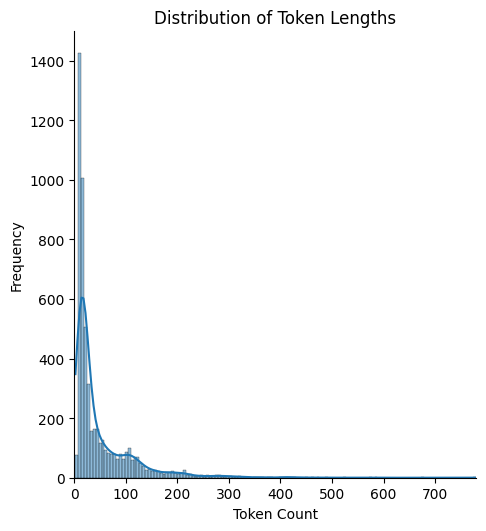

In [13]:
# Ensure all sentences are strings and handle NaN values
train_df["Sentence"] = train_df["Sentence"].astype(str).fillna("")
test_df["Sentence"] = test_df["Sentence"].astype(str).fillna("")

# Distribution of length of Sentence
all_data = train_df.Sentence.tolist() + test_df.Sentence.tolist()
all_data = [' '.join(simple_preprocess(str(text))) for text in all_data]  # Ensure text is string
encoded_text = [tokenizer.encode(text, add_special_tokens=True) for text in all_data]
token_lens = [len(text) for text in encoded_text]

# Plot distribution
sns.displot(token_lens, kde=True)
plt.xlim([0, max(token_lens)])
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()


Xây dựng mô hình

In [14]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

Huấn luyện và đánh giá mô hình

In [15]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
    
    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)

In [16]:
def prepare_loaders(df, fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SentimentDataset(df_train, tokenizer, max_len=120)
    valid_dataset = SentimentDataset(df_valid, tokenizer, max_len=120)
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)
    
    return train_loader, valid_loader

In [17]:
patience = 3  # Số epoch không cải thiện trước khi dừng
early_stopping_counter = 0

for fold in range(skf.n_splits):
    print(f'-----------Fold: {fold+1} ------------------')
    train_loader, valid_loader = prepare_loaders(train_df, fold=fold)
    model = SentimentClassifier(n_classes=3).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=len(train_loader) * EPOCHS
    )

    best_acc = 0
    early_stopping_counter = 0  # Reset bộ đếm cho mỗi fold

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch+1}/{EPOCHS}')
        print('-'*30)

        train(model, criterion, optimizer, train_loader)
        val_acc = eval()

        if val_acc > best_acc:
            torch.save(model.state_dict(), f'phobert_fold{fold+1}.pth')
            best_acc = val_acc
            early_stopping_counter = 0  # Reset bộ đếm nếu có cải thiện
        else:
            early_stopping_counter += 1  # Tăng bộ đếm nếu không cải thiện

        if early_stopping_counter >= patience:
            print(f'⏹️ Early stopping at epoch {epoch+1} for fold {fold+1}')
            break  # Dừng huấn luyện


-----------Fold: 1 ------------------


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch 1/10
------------------------------
Train Accuracy: 0.8105499438832773 Loss: 0.5109972708114159
Valid Accuracy: 0.8888888888888888 Loss: 0.29544640236323877
Epoch 2/10
------------------------------
Train Accuracy: 0.9048260381593715 Loss: 0.2819676070096886
Valid Accuracy: 0.9030303030303031 Loss: 0.29103452874527824
Epoch 3/10
------------------------------
Train Accuracy: 0.9355780022446689 Loss: 0.21579045605074654
Valid Accuracy: 0.9292929292929293 Loss: 0.24487942829728127
Epoch 4/10
------------------------------
Train Accuracy: 0.9537598204264871 Loss: 0.15689300279396728
Valid Accuracy: 0.9313131313131313 Loss: 0.24384188341097005
Epoch 5/10
------------------------------
Train Accuracy: 0.9692480359147025 Loss: 0.11874081981852383
Valid Accuracy: 0.9151515151515152 Loss: 0.3773794979938576
Epoch 6/10
------------------------------
Train Accuracy: 0.9728395061728395 Loss: 0.10149065570782297
Valid Accuracy: 0.9212121212121213 Loss: 0.3543319484639552
Epoch 7/10
---------

Dự đoán trên dữ liệu mới

In [18]:
def test_kfold(data_loader):
    models = []
    for fold in range(skf.n_splits):
        model = SentimentClassifier(n_classes=3)
        model.to(device)
        model.load_state_dict(torch.load(f'phobert_fold{fold+1}.pth'))
        model.eval()
        models.append(model)

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
        texts.extend(text)
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [19]:
test_dataset = SentimentDataset(test_df, tokenizer, max_len=50)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test_kfold(test_loader)

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       242
           1       0.94      0.85      0.90       226
           2       0.93      0.95      0.94        83

    accuracy                           0.91       551
   macro avg       0.92      0.92      0.92       551
weighted avg       0.92      0.91      0.91       551



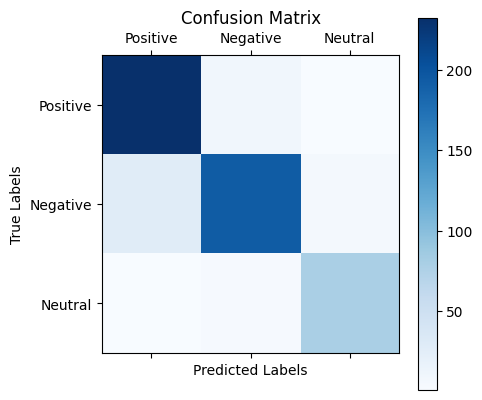

In [20]:
class_names = ['Positive', 'Negative', 'Neutral']

cm = confusion_matrix(real_values, predicts)

plt.matshow(cm, cmap='Blues')
plt.colorbar()

# Thêm nhãn lớp vào trục X và Y
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
def check_wrong(real_values, predicts):
    wrong_arr = []
    wrong_label = []
    for i in range(len(predicts)):
        if predicts[i] != real_values[i]:
            wrong_arr.append(i)
            wrong_label.append(predicts[i])
    return wrong_arr, wrong_label

for i in range(15):
    print('-'*50)
    wrong_arr, wrong_label = check_wrong(real_values, predicts)
    print(test_df.iloc[wrong_arr[i]].Sentence)
    print(f'Predicted: ({class_names[wrong_label[i]]}) --vs-- Real label: ({class_names[real_values[wrong_arr[i]]]})')

--------------------------------------------------
Cà phê sữa đá quá nhiều đá, uống vài ngụm đã hết, không đáng với số tiền bỏ ra.
Predicted: (Positive) --vs-- Real label: (Negative)
--------------------------------------------------
Trà đào mà ko có lát đào nào, chỉ có nước thôi là sao?
Predicted: (Positive) --vs-- Real label: (Negative)
--------------------------------------------------
Hôm nay qua ăn cơm cửa hàng Lovjng Hut, thấy khá là ngon, cơm rẻo. Của hàng khá yên tĩnh, like.
Predicted: (Positive) --vs-- Real label: (Negative)
--------------------------------------------------
Quán này decor đẹp, sống ảo cháy máy, mà nước cũng ngon nữa!
Predicted: (Positive) --vs-- Real label: (Negative)
--------------------------------------------------
Nhân viên rất dễ thương, nhiệt tình giúp mình chọn đồ uống!
Predicted: (Neutral) --vs-- Real label: (Negative)
--------------------------------------------------
Mấy ngày nay hnao cũng gọi cơm về ăn. Mà hnay ăn cơm khô dã man, vị khác với bình t

In [22]:
def infer(text, tokenizer, max_len=120):
    print(f'Text: {text}')
    text = ' '.join(simple_preprocess(text))
    text = ViTokenizer.tokenize(text)
    
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )

    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Sentiment: {class_names[y_pred]}')

In [37]:
infer('đồ uống như cức uống vô thành tiên luôn', tokenizer)

Text: đồ uống như cức uống vô thành tiên luôn
Sentiment: Positive


In [38]:
!pip freeze

absl-py==1.4.0
accelerate==1.2.1
aiofiles==22.1.0
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
aiosqlite==0.21.0
alabaster==1.0.0
albucore==0.0.19
albumentations==1.4.20
alembic==1.14.1
altair==5.5.0
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
antlr4-python3-runtime==4.9.3
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
args==0.1.0
array_record==0.5.1
arrow==1.3.0
arviz==0.20.0
astropy==6.1.7
astropy-iers-data==0.2024.12.16.0.35.48
asttokens==3.0.0
astunparse==1.6.3
async-timeout==5.0.1
atpublic==4.1.0
attrs==25.1.0
audioread==3.0.1
autograd==1.7.0
babel==2.16.0
backcall==0.2.0
bayesian-optimization==2.0.3
beautifulsoup4==4.12.3
betterproto==2.0.0b6
bigframes==1.29.0
bigquery-magics==0.4.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blobfile==3.0.0
blosc2==2.7.1
bokeh==3.6.2
Boruta==0.4.3
boto3==1.36.13
botocore==1.36.13
Bottleneck==1.4.2
-e git+https://github.com/SohierDane/BigQuery_Helper@8615a7f6c1663e7f2d48aa2b32c2dbcb600a440f#egg=bq_helper
bqplo